In [1]:
# -*- coding: utf-8 -*-
# Create time: 2025-09-29
# Update time: 2025-11-27

# conda activate benchmark
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
import umap
import pickle
import os
plt.rcParams['svg.fonttype'] = 'none'

def load_and_process_data(h5ad_file, batch_col='batch', celltype_col='celltype', embedding_key='X_pca'):
    """
    加载h5ad文件并处理数据
    """
    print(f"正在加载文件: {h5ad_file}")
    adata = sc.read_h5ad(h5ad_file)
    
    # 检查必要的列是否存在
    if batch_col not in adata.obs.columns:
        raise ValueError(f"obs中未找到列: {batch_col}")
    if celltype_col not in adata.obs.columns:
        raise ValueError(f"obs中未找到列: {celltype_col}")
    if embedding_key not in adata.obsm.keys():
        raise ValueError(f"obsm中未找到键: {embedding_key}")
    
    print(f"数据形状: {adata.shape}")
    print(f"批次数量: {adata.obs[batch_col].nunique()}")
    print(f"细胞类型数量: {adata.obs[celltype_col].nunique()}")
    
    return adata

def calculate_batch_celltype_embeddings(adata, batch_col='batch', celltype_col='celltype', embedding_key='X_pca'):
    """
    计算每个batch-celltype组合的平均embedding
    """
    print("正在计算batch-celltype平均embedding...")
    
    # 获取embedding数据
    embeddings = adata.obsm[embedding_key]
    obs_data = adata.obs[[batch_col, celltype_col]].copy()
    
    # 重置索引，确保索引是连续的整数
    obs_data = obs_data.reset_index(drop=True)
    
    # 创建batch-celltype组合
    obs_data['batch_celltype'] = obs_data[batch_col].astype(str) + '_' + obs_data[celltype_col].astype(str)
    
    # 计算每个组合的平均embedding
    batch_celltype_embeddings = []
    batch_celltype_info = []
    
    for group_name, group_indices in obs_data.groupby('batch_celltype').groups.items():
        batch_name = obs_data.loc[group_indices[0], batch_col]
        celltype_name = obs_data.loc[group_indices[0], celltype_col]
        
        # 确保索引是整数类型的numpy数组
        group_indices_array = np.array(group_indices, dtype=int)
        
        # 计算该组的平均embedding
        group_embedding = embeddings[group_indices_array].mean(axis=0)
        
        batch_celltype_embeddings.append(group_embedding)
        batch_celltype_info.append({
            'batch': batch_name,
            'celltype': celltype_name,
            'batch_celltype': group_name,
            'cell_count': len(group_indices_array)
        })
    
    batch_celltype_embeddings = np.array(batch_celltype_embeddings)
    batch_celltype_df = pd.DataFrame(batch_celltype_info)
    
    print(f"生成了 {len(batch_celltype_embeddings)} 个batch-celltype组合")
    return batch_celltype_embeddings, batch_celltype_df

def perform_dimensionality_reduction(embeddings, method='umap', random_state=42):
    """
    执行降维分析
    """
    print(f"正在计算{method.upper()}降维结果...")

    if method.lower() == 'umap':
        reducer = umap.UMAP(random_state=random_state, n_neighbors=15, min_dist=0.1)
    elif method.lower() == 'tsne':
        reducer = TSNE(random_state=random_state, perplexity=min(30, len(embeddings)-1))
    else:
        raise ValueError("method必须是'umap'或'tsne'")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

def compute_all_reductions(original_embeddings, centered_embeddings, output_dir=None):
    """
    计算所有降维结果并可选择性保存到文件
    """
    print("开始计算所有降维结果...")
    
    # 计算所有降维结果
    reductions = {}
    
    print("计算原始embedding的降维...")
    reductions['original_tsne'] = perform_dimensionality_reduction(original_embeddings, 'tsne')
    reductions['original_umap'] = perform_dimensionality_reduction(original_embeddings, 'umap')
    
    print("计算中心化embedding的降维...")
    reductions['centered_tsne'] = perform_dimensionality_reduction(centered_embeddings, 'tsne')
    reductions['centered_umap'] = perform_dimensionality_reduction(centered_embeddings, 'umap')
    
    # 如果提供了输出目录，则保存结果
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
        reduction_file = os.path.join(output_dir, 'reduction_results.pkl')
        with open(reduction_file, 'wb') as f:
            pickle.dump(reductions, f)
        print(f"降维结果已保存到: {reduction_file}")
    
    return reductions

def load_reduction_results(output_dir):
    """
    从文件加载降维结果
    """
    reduction_file = os.path.join(output_dir, 'reduction_results.pkl')
    if not os.path.exists(reduction_file):
        return None
    
    with open(reduction_file, 'rb') as f:
        reductions = pickle.load(f)
    
    print(f"从文件加载降维结果: {reduction_file}")
    return reductions

def center_embeddings_by_batch(batch_celltype_embeddings, batch_celltype_df):
    """
    对每个batch内的celltype embedding进行中心化处理
    """
    print("正在进行批次内中心化处理...")
    
    centered_embeddings = batch_celltype_embeddings.copy()
    
    # 对每个batch进行处理
    for batch in batch_celltype_df['batch'].unique():
        batch_mask = batch_celltype_df['batch'] == batch
        batch_indices = np.where(batch_mask)[0]
        
        # 计算该batch内所有celltype embedding的平均值
        batch_mean = batch_celltype_embeddings[batch_indices].mean(axis=0)
        
        # 从该batch的所有embedding中减去平均值
        centered_embeddings[batch_indices] = batch_celltype_embeddings[batch_indices] - batch_mean
        
        print(f"Batch {batch}: {len(batch_indices)} 个celltype进行了中心化")
    
    return centered_embeddings

def center_embeddings_by_batch_cells(batch_celltype_embeddings, batch_celltype_df, adata, 
                                    batch_col='batch', embedding_key='X_emb', max_cells_per_batch=10000):
    """
    对每个batch内的celltype embedding进行中心化处理
    使用batch中所有cell embedding的平均值作为中心点
    
    参数:
    batch_celltype_embeddings: batch-celltype平均embedding
    batch_celltype_df: batch-celltype信息表  
    adata: 原始数据
    batch_col: batch列名
    embedding_key: embedding键名
    max_cells_per_batch: 每个batch最大采样细胞数，超过则随机采样
    """
    print("正在进行批次内中心化处理（基于所有细胞embedding）...")
    
    centered_embeddings = batch_celltype_embeddings.copy()
    
    # 获取原始cell embedding数据
    all_cell_embeddings = adata.obsm[embedding_key]
    
    # 对每个batch进行处理
    for batch in batch_celltype_df['batch'].unique():
        # 获取该batch的所有细胞
        batch_cell_mask = adata.obs[batch_col] == batch
        batch_cell_indices = np.where(batch_cell_mask)[0]
        
        # 如果细胞数超过阈值，随机采样
        if len(batch_cell_indices) > max_cells_per_batch:
            print(f"Batch {batch}: 细胞数 {len(batch_cell_indices)} 超过阈值 {max_cells_per_batch}，进行随机采样")
            np.random.seed(42)  # 设置随机种子保证可重现性
            batch_cell_indices = np.random.choice(batch_cell_indices, max_cells_per_batch, replace=False)
        
        # 计算该batch内所有（采样后的）细胞embedding的平均值
        batch_cell_mean = all_cell_embeddings[batch_cell_indices].mean(axis=0)
        
        # 获取该batch对应的batch-celltype组合索引
        batch_celltype_mask = batch_celltype_df['batch'] == batch
        batch_celltype_indices = np.where(batch_celltype_mask)[0]
        
        # 从该batch的所有batch-celltype embedding中减去细胞平均值
        centered_embeddings[batch_celltype_indices] = batch_celltype_embeddings[batch_celltype_indices] - batch_cell_mean
        
        print(f"Batch {batch}: 使用 {len(batch_cell_indices)} 个细胞的平均embedding对 {len(batch_celltype_indices)} 个celltype进行了中心化")
    
    return centered_embeddings

def prepare_analysis_data(input_file, batch_col='batch', celltype_col='celltype', 
                         embedding_key='X_pca', output_dir=None, force_recompute=False,
                         center_method='celltype', max_cells_per_batch=10000):
    """
    准备分析所需的所有数据，返回用于绘图的数据结构
    
    参数:
    input_file: 输入h5ad文件路径
    batch_col: batch列名
    celltype_col: celltype列名
    embedding_key: embedding键名
    output_dir: 输出目录
    force_recompute: 是否强制重新计算
    center_method: 中心化方法，'celltype'或'cells'
        - 'celltype': 使用batch中所有celltype embedding的平均值
        - 'cells': 使用batch中所有cell embedding的平均值
    max_cells_per_batch: 当center_method='cells'时，每个batch最大采样细胞数
    
    返回:
    - adata: 原始数据
    - batch_celltype_df: batch-celltype信息表
    - reductions: 降维结果字典
    - original_embeddings: 原始embedding
    - centered_embeddings: 中心化embedding
    """
    # 创建输出文件夹
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
    
    # 1. 加载数据
    adata = load_and_process_data(input_file, batch_col, celltype_col, embedding_key)
    
    # 2. 计算batch-celltype平均embedding
    batch_celltype_embeddings, batch_celltype_df = calculate_batch_celltype_embeddings(
        adata, batch_col, celltype_col, embedding_key
    )
    
    # 3. 批次内中心化实验 - 根据方法选择
    if center_method == 'celltype':
        print("使用celltype平均值进行中心化")
        centered_embeddings = center_embeddings_by_batch(batch_celltype_embeddings, batch_celltype_df)
    elif center_method == 'cells':
        print("使用细胞平均值进行中心化")
        centered_embeddings = center_embeddings_by_batch_cells(
            batch_celltype_embeddings, batch_celltype_df, adata, 
            batch_col, embedding_key, max_cells_per_batch
        )
    else:
        raise ValueError("center_method必须是'celltype'或'cells'")

    # 4. 计算或加载降维结果
    reductions = None
    if output_dir is not None and not force_recompute:
        reductions = load_reduction_results(output_dir)
    
    if reductions is None:
        reductions = compute_all_reductions(batch_celltype_embeddings, centered_embeddings, output_dir)
    
    print("数据准备完成！")
    
    return {
        'adata': adata,
        'batch_celltype_df': batch_celltype_df,
        'reductions': reductions,
        'original_embeddings': batch_celltype_embeddings,
        'centered_embeddings': centered_embeddings
    }


In [ ]:

def visualize_embeddings_combined(data_dict, celltype_col='celltype', save_dir=None, 
                                figsize=(16, 12)):
    """
    生成组合可视化图：左右为原始/中心化
    
    参数:
    data_dict: prepare_analysis_data返回的数据字典
    """
    print("正在生成可视化图...")
    
    # 从数据字典中提取数据
    reductions = data_dict['reductions']
    batch_celltype_df = data_dict['batch_celltype_df']
    adata = data_dict['adata']
    
    # 全局字体设置
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 6

    # 创建图形
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # 准备数据
    batches = batch_celltype_df['batch'].unique()
    celltypes = batch_celltype_df['celltype'].unique()

    # 定义形状
    markers = ["o","s","^","v","<",">","D","d","p","h","H","P","X","*", "8", "4"]
    batch_marker_map = {batch: markers[i % len(markers)] for i, batch in enumerate(batches)}
    
    # 设置颜色 - 优先使用adata.uns中的颜色
    celltype_color_map = {}
    celltype_color_key = f"{celltype_col}_colors"
    
    if celltype_color_key in adata.uns:
        # 使用adata.uns中的颜色
        print(f"使用adata.uns中的颜色: {celltype_color_key}")
        celltype_categories = adata.obs[celltype_col].cat.categories
        celltype_colors = adata.uns[celltype_color_key]
        celltype_color_map = dict(zip(celltype_categories, celltype_colors))
        
        # 确保所有celltype都有颜色
        for ct in celltypes:
            if ct not in celltype_color_map:
                print(f"警告: {ct} 在uns颜色中未找到，使用默认颜色")
                celltype_color_map[ct] = plt.cm.Set3(len(celltype_color_map) % 12)
    else:
        # 使用默认颜色
        print(f"未找到{celltype_color_key}，使用默认颜色")
        colors = plt.cm.Set3(np.linspace(0, 1, len(celltypes)))
        celltype_color_map = {celltype: colors[i] for i, celltype in enumerate(celltypes)}
    
    # 定义子图数据和标题
    plot_data = [
        (reductions['original_umap'], "Raw embedding", axes[0]),
        (reductions['centered_umap'], "Batch-centered embedding", axes[1]),
    ]
    
    # 绘制所有子图
    for coords, title, ax in plot_data:
        for i, row in batch_celltype_df.iterrows():
            x, y = coords[i]
            batch = row['batch']
            celltype = row['celltype']
            
            ax.scatter(x, y, 
                      c=[celltype_color_map[celltype]], 
                      marker=batch_marker_map[batch],
                      s=30, alpha=0.8, edgecolors='black', linewidth=0.25)
        
        ax.set_title(title, fontsize=7)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        # 设置框线宽度
        for spine in ax.spines.values():
            spine.set_linewidth(0.5)

    # 调整子图布局，为图例留出空间
    plt.subplots_adjust(bottom=0.4)
    
    # 创建图例
    # Celltype图例 (颜色) - 放在左侧，3列布局
    sorted_celltype_categories = sorted(celltypes, key=len)
    celltype_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor=celltype_color_map[ct], markersize=5, alpha=0.9)
                       for ct in sorted_celltype_categories]
    celltype_legend = fig.legend(celltype_handles, sorted_celltype_categories, title="Cell Type", 
                                loc='lower center', bbox_to_anchor=(0.4, 0.02),
                                fontsize=6, title_fontsize=7,
                                frameon=False, 
                                ncol=3, columnspacing=0, handletextpad=0)
    
    # Batch图例 (形状) - 放在右侧，3列布局
    batch_handles = [plt.Line2D([0], [0], marker=batch_marker_map[batch], color='gray', 
                               markersize=3, alpha=0.9, linestyle='None')
                    for batch in batches]
    batch_legend = fig.legend(batch_handles, batches, title="Batch", 
                             loc='lower center', bbox_to_anchor=(0.8, 0.02),
                             fontsize=6, title_fontsize=7,
                             frameon=False,
                             ncol=3, columnspacing=0, handletextpad=0)
    # 添加图形标题
    fig.suptitle("scFM: Geneformer", fontsize=7, y=1.03, fontweight='bold')

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, "Figure2E_celltype_embedding.pdf"), bbox_inches="tight")
        plt.savefig(os.path.join(save_dir, "Figure2E_celltype_embedding.svg"), bbox_inches="tight")
        plt.savefig(os.path.join(save_dir, "Figure2E_celltype_embedding.jpg"), dpi=600, bbox_inches="tight")

    plt.show()
    return fig, axes


In [3]:
data = prepare_analysis_data(
    input_file="/home/wanglinting/scFM/Result/liver/geneformer/Embeddings_geneformer.h5ad",
    batch_col="donor_id", 
    celltype_col="cell_type", 
    embedding_key="X_emb",
    center_method='cells',
    force_recompute=False,
    output_dir="/home/wanglinting/scFM/Result/liver/geneformer",
)

正在加载文件: /home/wanglinting/scFM/Result/liver/geneformer/Embeddings_geneformer.h5ad
数据形状: (68429, 33159)
批次数量: 16
细胞类型数量: 18
正在计算batch-celltype平均embedding...
生成了 252 个batch-celltype组合
使用细胞平均值进行中心化
正在进行批次内中心化处理（基于所有细胞embedding）...
Batch C102: 使用 3169 个细胞的平均embedding对 17 个celltype进行了中心化
Batch C104: 使用 6237 个细胞的平均embedding对 18 个celltype进行了中心化
Batch C105: 使用 8063 个细胞的平均embedding对 18 个celltype进行了中心化
Batch C113: 使用 2016 个细胞的平均embedding对 16 个celltype进行了中心化
Batch C115: 使用 9415 个细胞的平均embedding对 18 个celltype进行了中心化
Batch C39: 使用 4417 个细胞的平均embedding对 16 个celltype进行了中心化
Batch C54: 使用 4295 个细胞的平均embedding对 16 个celltype进行了中心化
Batch C64: 使用 612 个细胞的平均embedding对 15 个celltype进行了中心化
Batch C68: 使用 888 个细胞的平均embedding对 7 个celltype进行了中心化
Batch C70: 使用 806 个细胞的平均embedding对 12 个celltype进行了中心化
Batch C82: 使用 506 个细胞的平均embedding对 16 个celltype进行了中心化
Batch C85: 使用 5892 个细胞的平均embedding对 17 个celltype进行了中心化
Batch C88: 使用 2914 个细胞的平均embedding对 17 个celltype进行了中心化
Batch C93: 使用 1061 个细胞的平均embedding对 15 个celltype进行了中心化
Ba

正在生成可视化图...
使用adata.uns中的颜色: cell_type_colors


/tmp/ipykernel_3480728/3597303350.py:66: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('4').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


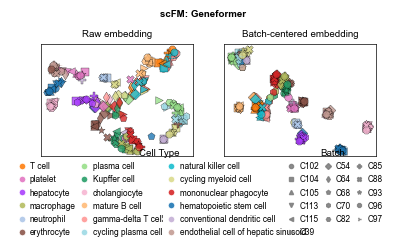

(<Figure size 433.071x232.283 with 2 Axes>,
 array([<Axes: title={'center': 'Raw embedding'}>,
        <Axes: title={'center': 'Batch-centered embedding'}>], dtype=object))

In [20]:
# cm 转 inch
cm_to_inch = 1 / 2.54

visualize_embeddings_combined(data, celltype_col='cell_type', figsize=(11*cm_to_inch, 5.9*cm_to_inch),
    save_dir="/home/wanglinting/scFM/Result/figure")